In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [11]:
train_im = torchvision.datasets.FashionMNIST(root = '.',
                                  train = True,
                                  transform = transforms.ToTensor(),
                                  download = True)
test_im = torchvision.datasets.FashionMNIST(root = '.',
                                  train = False,
                                  transform = transforms.ToTensor(),
                                  download = True)

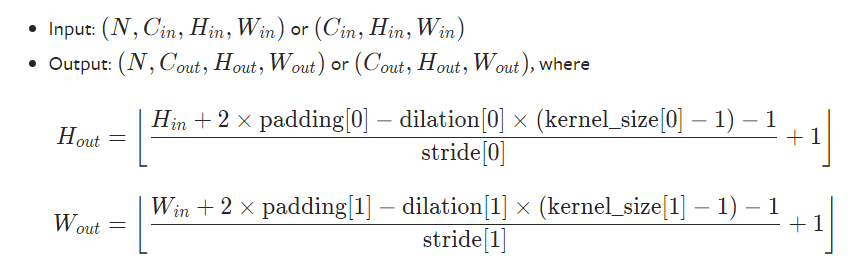

In [12]:
class CNN(nn.Module):

  def __init__(self, K):
    super().__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        # h_out = floor((28+2*0-1*(3-1)-1)/2+1) = 13
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        # h_out = floor((13+2*0-1*(3-1)-1)/2+1) = 6
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        # h_out = floor((6+2*0-1*(3-1)-1)/2+1) = 2
        nn.ReLU()
    )

    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128*2*2, out_features=128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, out_features=K),
        nn.ReLU()
    )

  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out






In [13]:
k = len(train_im.targets.unique())


In [14]:
model = CNN(k)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [16]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(dev)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): ReLU()
  )
)

In [17]:
b_size = 128
train_dl = torch.utils.data.DataLoader(train_im,
                                       batch_size = b_size,
                                       shuffle = True
                                       )

test_dl = torch.utils.data.DataLoader(test_im,
                                       batch_size = b_size,
                                       shuffle = True
                                       )

In [18]:
epoches = 15
train_losses = []
test_losses = []
for i in range(epoches):
  train_loss = []
  test_loss = []
  model.train()
  for input, target in train_dl:
    input, target = input.to(dev), target.to(dev)
    outs = model(input)
    optimizer.zero_grad()
    loss = criterion(outs, target)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

  train_losses.append(np.mean(train_loss))

  model.eval()
  for inp, tar in test_dl:
    inp, tar = inp.to(dev), tar.to(dev)
    t_out = model(inp)
    t_loss = criterion(t_out, tar)
    test_loss.append(t_loss.item())

  test_losses.append(np.mean(test_loss))

  print(f'iteration : {i+1}/{epoches}    Train loss: {np.mean(train_loss)}     Test loss: {np.mean(test_loss)}')

iteration : 1/15    Train loss: 0.726864248450631     Test loss: 0.4937014251570158
iteration : 2/15    Train loss: 0.46165929852264015     Test loss: 0.4244329985938495
iteration : 3/15    Train loss: 0.4082411174009095     Test loss: 0.3980051512959637
iteration : 4/15    Train loss: 0.37522729719752695     Test loss: 0.3619567804698703
iteration : 5/15    Train loss: 0.3480973780981259     Test loss: 0.3529208994741681
iteration : 6/15    Train loss: 0.328549051240309     Test loss: 0.33059903394572343
iteration : 7/15    Train loss: 0.30900848451962093     Test loss: 0.323172676978232
iteration : 8/15    Train loss: 0.2928472035792845     Test loss: 0.3143818359586257
iteration : 9/15    Train loss: 0.2787525261134735     Test loss: 0.2996036840390556
iteration : 10/15    Train loss: 0.26294530761330875     Test loss: 0.3026558936019487
iteration : 11/15    Train loss: 0.24943955789115638     Test loss: 0.2976495244457752
iteration : 12/15    Train loss: 0.2406784560857043     Test

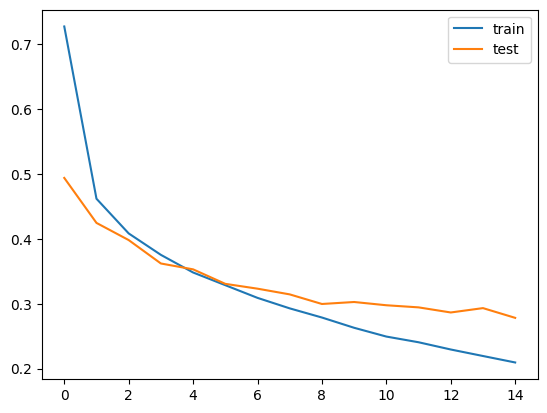

In [22]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

In [24]:
train_im.targets.numpy()

array([9, 0, 0, ..., 3, 0, 5])

In [56]:
model.eval()
train_preds = []
train_targets = []
test_preds = []
test_targets = []

for inp, tar in train_dl:
  inp, tar = inp.to(dev), tar.to(dev)
  out = model(inp)
  _, pred = torch.max(out,1)
  train_preds.extend(pred.tolist())
  train_targets.extend(tar.tolist())

for inp, tar in test_dl:
  inp, tar = inp.to(dev), tar.to(dev)
  out = model(inp)
  _, y_pred = torch.max(out,1)
  test_preds.extend(y_pred.tolist())
  test_targets.extend(tar.tolist())


In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


<Axes: >

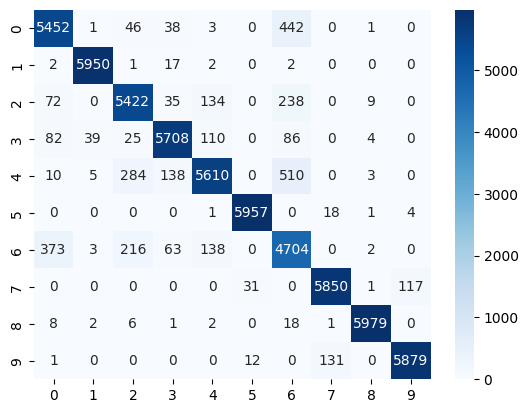

In [58]:
sns.heatmap(confusion_matrix(train_preds, train_targets), cmap="Blues", annot=True, fmt='d')

<Axes: >

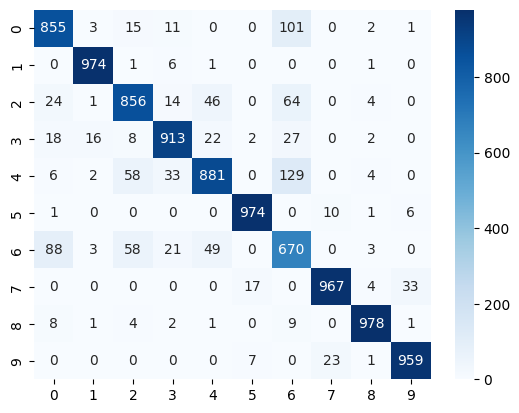

In [59]:
sns.heatmap(confusion_matrix(test_preds, test_targets), cmap="Blues", annot=True, fmt='d')

In [61]:
from sklearn.metrics import accuracy_score
print(f'accuracy of train: {accuracy_score(train_preds, train_targets)*100}%')
print(f'accuracy of test: {accuracy_score(test_preds, test_targets)*100}%')


accuracy of train: 94.185%
accuracy of test: 90.27%
